# Finding lane lines on the road<a class="tocSkip">

### [Udacity](https://www.udacity.com/) Program: Autonomous Vehicle Engineer, Project 1<a class="tocSkip">
---

When we drive, we use visual information to sense where we are and to decide where to go. The lines on the road show us where the lanes are, so we use them as our constant reference for where to steer the vehicle. 

In the process of developing an autonomous vehicle that works with existing roads, one of the first goals we would like to achieve is to automatically detect lane lines using computer vision.

This tool detects lane lines in images using Python and [OpenCV (Open-Source Computer Vision)](https://pypi.org/project/opencv-python/). OpenCV is a package that has many useful tools for analyzing images.

---
## Pipeline overview

The pipeline consists of 8 steps (not including the code needed to import image files), as follows:

1. Get image size and two-dimensional grid range, and assign values to variables.

2. Grayscale the image — calling helper function `grayscale()` — and apply Gaussian smoothing — calling helper function `gaussian_blur()`.

3. Apply Canny transform — calling helper function `canny()` — to get raw edges in the image. After some trial and error, I decide to use thresholds of `low=35` and `high=70`.

4. Create masked image of edges — calling helper function `region_of_interest()`. I define the vertices as percentages of the range of the image grid. Example: `(0.90*x_max, y_max)`.

5. Apply Hough transform to masked edges. Instead of calling the provided helper function `hough_lines()`, I call `cv2.HoughLinesP()` in order to get array of all Hough lines. I use the following parameters:
	* `rho = 1`
	* `theta = 1*np.pi/180`
	* `threshold = 4`
	* `min_line_len = 25`
	* `max_line_gap = 15`
	
6. Get end-points for each lane line by applying my new helper function, `lane_line()`, which takes Hough line segments and outputs two end-points for a single lane line (right or left). The `lane_line()` function works as follows:
	* Take original image to derive range of axes.
	* Take input side, `'right'` or `'left'`, and filter Hough lines into the requested lane side using the sign of the slope.
	* Take all lines from a single side, and calculate median slope and median intercept (I used the median to avoid too much distortion from outliers).
	* Derive line origin: using the median slope and intercept.
	* Derive line end-points: using origin, median slope, and lane distance.
	* Return line end-points.

7. Draw lane lines on blank image calling modified helper function `draw_lines()`, which I modify as follows:
	* Set default `thickness=12`.
	* Create blank image (i.e., all black) to draw lines on.
	* Take input lines as tuples of two points, as opposed to the output of `cv2.HoughLinesP()`.
	* Draw lane lines on blank image.

8. Add lane lines image to original image calling helper function `weighted_img()`.

---
## Import Python modules

In [16]:
# Import Python libraries  
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# Import libraries needed to edit/save/watch video clips
from IPython.display import HTML
from moviepy.editor import VideoFileClip

# Pretty display for Jupyter notebooks
%matplotlib inline

---
## Read in an image of the road

This image is a: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


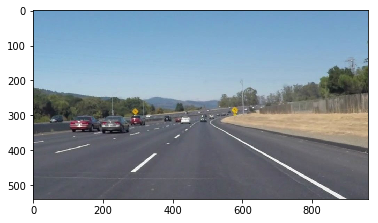

In [17]:
# Read in image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

# Print out some stats and display
print('This image is a:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

---
## Helper functions

Below are some helper functions provided by the Udacity instructors. I documented and modified the functions as needed.

In [18]:
def grayscale(img):
    """Apply the Grayscale transform and return an image with only one 
    color channel.
    
    Note: To see the returned image as grayscale you should call:
        >>> plt.imshow(grayscale(img), cmap='gray')
    
    Args:
        img (numpy.ndarray): Output of matplotlib.image.imread().
        
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    """Apply the Canny transform.
    
    Args:
        img (numpy.ndarray): Input image.
        low_threshold (float): First threshold for the hysteresis 
            procedure.
        high_threshold (float): Second threshold for the hysteresis 
            procedure.
    
    """
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Apply a Gaussian Noise kernel.
    
    Args:
        img (numpy.ndarray): Input image.
        kernel_size (int): Gaussian kernel size.
    
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """Apply an image mask. Only keeps the region of the image defined 
    by the polygon formed from `vertices`. The rest of the image is set 
    to black.
    
    Args:
        img (numpy.ndarray): Input image.
        vertices (numpy.ndarray): Vertices that define the polygon of 
            interest.
        
    """
    # Define a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Fill pixels inside the polygon
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
            
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """Return an image with Hough Lines drawn. `img` should be the 
    output of a Canny transform.
    
    Args:
        img (numpy.ndarray): Input image. Output of a Canny transform.
        rho (float): Distance resolution of the accumulator in pixels.
        theta (float): Angle resolution of the accumulator in radians.
        threshold (int): Accumulator threshold parameter. Only those 
            lines are returned that get enough votes (`> threshold`).
        min_line_len (float): Minimum line length. Line segments shorter 
            than that are rejected.
        max_line_gap (float): Maximum allowed gap between points on the 
            same line to link them. 
    
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, 
                            np.array([]), 
                            minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    return line_img


def weighted_img(initial_img, img, α=0.8, β=1., λ=0.):
    """Calculate the weighted sum of two arrays.    
        
    Note: `initial_img` and `img` must be the same shape.
    
    Args:
        initial_img (numpy.ndarray): Original input image before any 
            processing.
        img (numpy.ndarray): Output of hough_lines(). Should be a blank 
            image (i.e., all black) with lines drawn on it.
        α (float): Weight of the first array elements (initial_img).
        β (float): Weight of the second array elements (img).
        λ (float): Scalar added to each sum.
    
    """    
    return cv2.addWeighted(initial_img, α, img, β, λ)

---
## Build a pipeline: Lane finding in images

### Custom pipeline functions 

In [70]:
def draw_lines(lines, image_shape, color=[255, 0, 0], thickness=2):
    """Modify draw_lines() to draw blank background, and to take lines 
    as tuples of two points

    
    """  
    lane = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
    for line in lines:
        cv2.line(lane, line[0], line[1], color, thickness)
    return lane


def lane_line(image, hough_lines, side, lane_distance):
    """Transform Hough line segments into two end-points for given 
    lane: right or left.
    
    Args:  
        image: Input image.
        hough_lines: output of cv2.HoughLinesP().
        side: "right" or "left".
        lane_distance: Length of lane line.
        
    Returns: 
        near_point: Starting point of the lane: (x1, y1).
        far_point: Ending point of the lane: (x2, y2).
        
    """
    # Get grid max points
    x_max = image.shape[1] - 1
    y_max = image.shape[0] - 1

    # Separate Hough lines into lane side by their slope 
    if side == 'left':
        one_side_lines = np.array([
            (x1, y1, x2, y2) for line in hough_lines 
                                 for x1, y1, x2, y2 in line
                                     if (x1 < 0.5*image.shape[1] 
                                         and x2 < 0.5*image.shape[1])
                                     if ((y2 - y1)/(x2 - x1) < 0)
            ])
        
    elif side == 'right':
        one_side_lines = np.array([
            (x1, y1, x2, y2) for line in hough_lines 
                                 for x1, y1, x2, y2 in line
                                     if (x1 > 0.5*image.shape[1] 
                                         and x2 > 0.5*image.shape[1])
                                     if ((y2 - y1)/(x2 - x1) > 0)
            ])

    # Calculate median slope and median intercept for single side
    slope = np.median([(y2 - y1)/(x2 - x1) 
                       for x1, y1, x2, y2 in one_side_lines])
    
    b = np.median([y1 - x1*(y2 - y1)/(x2 - x1) 
                   for x1, y1, x2, y2 in one_side_lines])
    
    if np.isnan(slope) or np.isnan(b):
        return (0, 0), (0, 0)

    # Derive lane line origin (i.e. near_point) from slope and intercept
    origin = int((y_max - b) / slope)
    near_point = (origin, y_max)

    # Derive lane line end-point (i.e. far_point) 
    if side == 'left':
        far_point = (int(origin + abs(lane_distance / slope)),
                     int(y_max - lane_distance))
    elif side == 'right':
        far_point = (int(origin - abs(lane_distance / slope)),
                     int(y_max - lane_distance))

    # Return lane end-points    
    return near_point, far_point

### Draw lane lines on test images

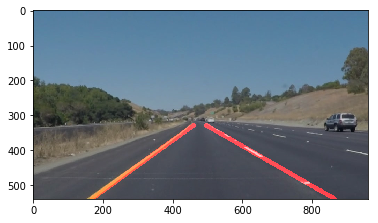

In [71]:
# Read image directory name and import file
test_images = os.listdir("test_images/")
name = test_images[0] 
image = mpimg.imread('test_images/' + name)

# Get image and grid sizes
imshape = image.shape
x_max = imshape[1] - 1
y_max = imshape[0] - 1

# Grayscale the image and apply Gaussian smoothing
gray = grayscale(image)
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Apply Canny transform to get raw edges
low_threshold = 35
high_threshold = 70
edges = canny(blur_gray, low_threshold, high_threshold) 

# Create masked image of edges
vertices = np.array([[(0.50*x_max, 0.55*y_max), (0.10*x_max, y_max), 
                      (0.90*x_max, y_max), (0.50*x_max, 0.55*y_max)]], 
                    dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

# Apply Hough transform. Get raw Hough lines
rho = 1              # distance resolution in pixels
theta = 1*np.pi/180  # angular resolution in radians 
threshold = 4        # minimum number of votes (intersections in grid)
min_line_len = 25    # in pixels
max_line_gap = 15    # in pixels   

hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, 
                              np.array([]), min_line_len, max_line_gap)

# Apply pipeline function `lane_line()` to get end-points 
lane_distance = 210
left_line = lane_line(image, hough_lines, 'left', lane_distance)    
right_line = lane_line(image, hough_lines, 'right', lane_distance)
lane_lines = left_line, right_line

# Draw lane on blank image (all black)
lane = draw_lines(lane_lines, imshape, color=[255, 0, 0], thickness=12)

# Add lanes image to original image
lane_image = weighted_img(image, lane, α=0.8, β=1., λ=0.)

# Plot processed image
plt.imshow(lane_image)

# Save processed image to output folder
mpimg.imsave('test_images_output/' + 'processed_' + name, lane_image)

---
## Test pipeline on short videos


The pipeline will be tested on two provided videos:

- `solidWhiteRight.mp4`

- `solidYellowLeft.mp4`

But first, I will build the lane finding pipeline into a function: `process_image()`. 

In [72]:
def process_image(image):
    """Transform Hough line segments into two end-points for given 
    lane: right or left.
    
    Args:  
        image: Input image.
        hough_lines: output of cv2.HoughLinesP().
        side: "right" or "left".
        lane_distance: Length of lane line.
        
    Returns: 
        near_point: Starting point of the lane: (x1, y1).
        far_point: Ending point of the lane: (x2, y2).
        
    """
    # Get image and grid sizes
    imshape = image.shape
    x_max = imshape[1] - 1
    y_max = imshape[0] - 1

    # Grayscale the image and apply Gaussian smoothing
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Apply Canny transform to get raw edges
    low_threshold = 35
    high_threshold = 70
    edges = canny(blur_gray, low_threshold, high_threshold) 

    # Create masked image of edges
    vertices = np.array([[(0.50*x_max, 0.55*y_max), (0.10*x_max, y_max), 
                          (0.90*x_max, y_max), (0.50*x_max, 0.55*y_max)]], 
                        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Apply Hough transform. Get raw Hough lines
    rho = 1                # distance resolution in pixels
    theta = 1*np.pi / 180  # angular resolution in radians 
    threshold = 4          # minimum number of votes
    min_line_len = 25      # in pixels
    max_line_gap = 15      # in pixels   

    hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, 
                                  np.array([]), min_line_len, max_line_gap)

    # Apply pipeline function `lane_line()` to get end-points 
    lane_distance = 210
    left_line = lane_line(image, hough_lines, 'left', lane_distance)    
    right_line = lane_line(image, hough_lines, 'right', lane_distance)
    lane_lines = left_line, right_line

    # Draw lane on blank image (all black)
    lane = draw_lines(lane_lines, imshape, color=[255, 0, 0], thickness=12)

    # Add lanes image to original image
    lane_image = weighted_img(image, lane, α=0.8, β=1., λ=0.)
    
    return lane_image

### Solid, white, right lane line

Below I rely on the module `moviepy.editor.VideoFileClip` to read in the video, `solidWhiteRight.mp4`, and to create a new clip whose frames are a transformation—through the finding-lane pipeline`process_image()`—of the frames of the current video.

In [85]:
# Read in test video -- solidWhiteRight.mp4
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

# Pass the clip, frame by frame, through the findling-lane pipeline
white_clip = clip1.fl_image(process_image) 

# Save processed video clip to disk
%time white_clip.write_videofile('test_videos_output/solidWhiteRight.mp4',\
                                 audio=False)





                                                    

                                                          
                                                             





                                                                


                                                       




                                               



t:  86%|████████▌ | 190/221 [6:15:21<00:00, 55.60it/s, now=None]

t:  86%|████████▌ | 190/221 [6:34:19<00:00, 58.53it/s, now=None]





t:  86%|████████▌ | 190/221 [6:44:43<00:00, 66.88it/s, now=None]A


t:  86%|████████▌ | 190/221 [6:18:49<00:00, 58.43it/s, now=None]




t:  86%|████████▌ | 190/221 [28:36<00:00, 59.53it/s, now=None]



                                                    

                                                          
                                                             





                                                                


                                                    

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4










t:   9%|▊         | 19/221 [00:00<00:02, 80.98it/s, now=None]






t:  14%|█▎        | 30/221 [00:00<00:02, 86.26it/s, now=None]






t:  18%|█▊        | 40/221 [00:00<00:02, 89.27it/s, now=None]






t:  22%|██▏       | 48/221 [00:00<00:02, 76.16it/s, now=None]






t:  25%|██▍       | 55/221 [00:00<00:02, 66.59it/s, now=None]






t:  28%|██▊       | 62/221 [00:00<00:02, 63.96it/s, now=None]






t:  31%|███       | 69/221 [00:00<00:02, 57.17it/s, now=None]






t:  34%|███▍      | 75/221 [00:01<00:02, 56.12it/s, now=None]






t:  37%|███▋      | 81/221 [00:01<00:02, 52.65it/s, now=None]






t:  39%|███▉      | 87/221 [00:01<00:02, 52.59it/s, now=None]






t:  42%|████▏     | 93/221 [00:01<00:02, 54.52it/s, now=None]






t:  45%|████▍     | 99/221 [00:01<00:02, 53.80it/s, now=None]






t:  48%|████▊     | 105/221 [00:01<00:02, 53.83it/s, now=None]






t:  50%|█████     | 111/221 [00:01<00:02, 50.99it/s, now=None]






t:  53%|█████▎    | 117/221 [00:01<00:0

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.39 s, sys: 586 ms, total: 3.98 s
Wall time: 4.92 s


**Play the processed video inline:**

In [86]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(white_output))

### Solid, yellow, left lane line

Now for the one with the solid yellow lane on the left. This one can be more difficult to get right.

In [88]:
# Read in test video -- solidYellowLeft.mp4
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

# Pass the clip, frame by frame, through the findling-lane pipeline
yellow_clip = clip2.fl_image(process_image)

# Save processed video clip to disk
%time yellow_clip.write_videofile('test_videos_output/solidYellowLeft.mp4',\
                                  audio=False)





                                                    

                                                          
                                                             





                                                                


                                                       




                                               



t:  86%|████████▌ | 190/221 [6:16:37<00:00, 55.60it/s, now=None]

t:  86%|████████▌ | 190/221 [6:35:35<00:00, 58.53it/s, now=None]





t:  86%|████████▌ | 190/221 [6:45:58<00:00, 66.88it/s, now=None]A


t:  86%|████████▌ | 190/221 [6:20:05<00:00, 58.43it/s, now=None]




t:  86%|████████▌ | 190/221 [29:52<00:00, 59.53it/s, now=None]



                                                    

                                                          
                                                             





                                                                


                                                    

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4










t:   3%|▎         | 18/681 [00:00<00:08, 80.04it/s, now=None]






t:   4%|▍         | 29/681 [00:00<00:07, 85.92it/s, now=None]






t:   6%|▌         | 40/681 [00:00<00:07, 89.90it/s, now=None]






t:   7%|▋         | 48/681 [00:00<00:08, 76.73it/s, now=None]






t:   8%|▊         | 55/681 [00:00<00:09, 66.73it/s, now=None]






t:   9%|▉         | 62/681 [00:00<00:09, 62.19it/s, now=None]






t:  10%|█         | 69/681 [00:00<00:09, 62.05it/s, now=None]






t:  11%|█         | 76/681 [00:01<00:09, 63.37it/s, now=None]






t:  12%|█▏        | 83/681 [00:01<00:10, 59.54it/s, now=None]






t:  13%|█▎        | 89/681 [00:01<00:10, 57.25it/s, now=None]






t:  14%|█▍        | 95/681 [00:01<00:10, 54.74it/s, now=None]






t:  15%|█▍        | 101/681 [00:01<00:12, 47.70it/s, now=None]






t:  16%|█▌        | 106/681 [00:01<00:13, 41.14it/s, now=None]






t:  16%|█▋        | 112/681 [00:01<00:12, 45.16it/s, now=None]






t:  17%|█▋        | 117/681 [00:01<00:









t:  75%|███████▌  | 512/681 [00:10<00:03, 48.99it/s, now=None]






t:  76%|███████▌  | 518/681 [00:10<00:03, 50.78it/s, now=None]






t:  77%|███████▋  | 524/681 [00:11<00:03, 51.69it/s, now=None]






t:  78%|███████▊  | 530/681 [00:11<00:02, 51.26it/s, now=None]






t:  79%|███████▊  | 536/681 [00:11<00:02, 52.75it/s, now=None]






t:  80%|███████▉  | 542/681 [00:11<00:02, 52.23it/s, now=None]






t:  81%|████████  | 549/681 [00:11<00:02, 54.54it/s, now=None]






t:  81%|████████▏ | 555/681 [00:11<00:02, 54.47it/s, now=None]






t:  82%|████████▏ | 561/681 [00:11<00:02, 52.37it/s, now=None]






t:  83%|████████▎ | 567/681 [00:11<00:02, 51.12it/s, now=None]






t:  84%|████████▍ | 573/681 [00:11<00:02, 51.54it/s, now=None]






t:  85%|████████▌ | 579/681 [00:12<00:02, 50.84it/s, now=None]






t:  86%|████████▌ | 585/681 [00:12<00:01, 53.06it/s, now=None]






t:  87%|████████▋ | 591/681 [00:12<00:01, 50.48it/s, now=None]






t:  88%|████████▊ | 597/68

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 11 s, sys: 1.72 s, total: 12.7 s
Wall time: 14.7 s


**Play the processed video inline:**

In [89]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(yellow_output))

### Challenge: Sharp turn and spotty road

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [90]:
# Read in test video -- challenge.mp4
clip3 = VideoFileClip('test_videos/challenge.mp4')

# Pass the clip, frame by frame, through the findling-lane pipeline
challenge_clip = clip3.fl_image(process_image)

# Save processed video clip to disk
%time challenge_clip.write_videofile('test_videos_output/challenge.mp4',\
                                     audio=False)





                                                    

                                                          
                                                             





                                                                


                                                       




                                               



t:  86%|████████▌ | 190/221 [6:18:37<00:00, 55.60it/s, now=None]

t:  86%|████████▌ | 190/221 [6:37:35<00:00, 58.53it/s, now=None]





t:  86%|████████▌ | 190/221 [6:47:59<00:00, 66.88it/s, now=None]A


t:  86%|████████▌ | 190/221 [6:22:05<00:00, 58.43it/s, now=None]




t:  86%|████████▌ | 190/221 [31:53<00:00, 59.53it/s, now=None]



                                                    

                                                          
                                                             





                                                                


                                                    

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4











t:   4%|▍         | 10/251 [00:00<00:05, 43.10it/s, now=None]






t:   6%|▌         | 15/251 [00:00<00:05, 42.97it/s, now=None]






t:   8%|▊         | 20/251 [00:00<00:05, 43.41it/s, now=None]






t:  10%|▉         | 24/251 [00:00<00:05, 42.23it/s, now=None]






t:  11%|█         | 28/251 [00:00<00:05, 39.07it/s, now=None]






t:  13%|█▎        | 32/251 [00:00<00:06, 36.33it/s, now=None]






t:  14%|█▍        | 36/251 [00:00<00:05, 36.16it/s, now=None]






t:  16%|█▌        | 40/251 [00:01<00:06, 34.54it/s, now=None]






t:  18%|█▊        | 44/251 [00:01<00:07, 29.03it/s, now=None]






t:  19%|█▊        | 47/251 [00:01<00:08, 23.59it/s, now=None]






t:  20%|█▉        | 50/251 [00:01<00:10, 18.89it/s, now=None]






t:  21%|██        | 53/251 [00:01<00:10, 19.24it/s, now=None]






t:  22%|██▏       | 56/251 [00:01<00:10, 18.24it/s, now=None]






t:  23%|██▎       | 58/251 [00:02<00:10, 18.35it/s, now=None]






t:  24%|██▍       | 61/251 [00:02<00:09,

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 9.08 s, sys: 1.55 s, total: 10.6 s
Wall time: 12 s


**Play the processed video inline:**

In [91]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(challenge_output))

---
## Shortcomings of the pipeline

1. The main shortcoming of this working tool is that it is susceptible to unexpected edges that may occur between the lane lines. Edges in the middle of the lane may contribute unwanted Hough lines (false positives) to the median statistics, used to extrapolate a single lane, than the actual lane-line edges; this problem may be especially exacerbated when the actual lane line is not solid.

2. The other shortcoming of the tool is that it is not optimized for video, which makes the output lane lines a little unstable and shaky on video.

### Recommendations for improvement

The most important goal for improvement would be to make the tool more robust to edges in the middle of the lane. The following ideas come to mind:

1. Implement a more sophisticated separation of Hough lines; one option would be to define three categories of Hough lines, based on their slope: right line, left line, and noise-edges. This may perform better than the binary demarcation into right line and left line.

2. Take into account the logical relation between the two lines of a lane, in order to rule out unreasonable cases. For example, we may want to write rules about the admissible range of angles at which the extrapolated lane lines may cross (i.e. a 90 degree vertex would be suspicious).
    

In order to address the shortcoming concerning the application of the tool to a video stream (shortcoming #2 of the previous section), a possible improvement would be to include a smoothing function. The smoothing function would take advantage of the fact that when we are processing video the successive images are not independent from each other. In other words, there is useful information about the position of the lane lines that may be carried over to the processing of the next image in the series. I presume there is a way to do this so that the video output looks smoother.